Import libraries and packages and load change detection dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_multiotsu

import models.gcd_vi_models as gcd_vi_models
import utils.gcd_utils as gcd_utils


base_dir = os.getcwd()
datasets_dir = os.path.join(base_dir,'datasets')

# Load dataset
#dataset_name = 'Atlantico'
#dataset_name = 'California'
dataset_name = 'Toulouse'
dataset = gcd_utils.dataset_loader(datasets_dir,dataset_name)

print('pre-event image size {shape}'.format(shape=dataset['before'].shape))
print('post-event image size {shape}'.format(shape=dataset['after'].shape))
print(dataset['metadata'])

pre-event image size (2000, 2000, 3)
post-event image size (2000, 2000, 3)
{'name': 'Toulouse-1', 'pre-event captured by': 'TerraSAR-X', 'post-event captured by': 'Pleiades'}


Implement preprocessing pipeline and graph structure learning from average signals,
extracted from pre and post event images.

In [2]:
num_spixels = 2400
r = 2
prepro_params = {'sp_method': 'slic',
                 'iqr_clipping':False,
                 'robust_avg_signals':True} # controls 

# Segments image space into superpixels (or segments), and 
# extract average and feature signals from pre and post event images at the superpixels.
X_mean, X, F, segments = gcd_utils.prepro_pipeline(dataset,num_spixels,r,prepro_params)

# Infer graph G from avg. signals using Kalofolia's graph structure learning model 
n = X_mean[0].shape[0] # number of nodes

gl_params = {'model': 'Kalofolias', # or 'Gaussian'
                'k': int(np.sqrt(n)),
                'knn_edge_cons': True,
                'k_': 5*int(np.sqrt(n)),
                'fusion_rule': 'sum', 
                'tol': 1e-5 # stopping tolerance
                }
W, outparams = gcd_utils.construct_adj_matrix(X_mean, gl_params)

Relative change of primal, dual variables, and objective fun

iter 0 : inf inf [41147.1956118]
iter 1 : 0.5909751787210712 0.6736612769645134 [8603.84288147]
iter 2 : 0.567801827818846 0.2302633497193515 [3798.43986968]
iter 3 : 0.42973332618331556 0.13222801495192615 [3015.7925858]


c:\Users\juanf\OneDrive\Documents\GitHub\Exploiting-variational-inequalities-for-generalized-change-detection-on-graphs\utils\gl\src\prox.py:120: RuntimeWarning: divide by zero encountered in log
  'final_eval': -gamma * np.sum(np.log(utils.reshape_as_column(x)),axis = 0),
c:\Users\juanf\OneDrive\Documents\GitHub\Exploiting-variational-inequalities-for-generalized-change-detection-on-graphs\utils\gl\src\gl_models.py:341: RuntimeWarning: divide by zero encountered in scalar divide
  rel_norm_primal = np.linalg.norm(-Y_n + Q_n,'fro')/np.linalg.norm(w,'fro')
c:\Users\juanf\OneDrive\Documents\GitHub\Exploiting-variational-inequalities-for-generalized-change-detection-on-graphs\utils\gl\src\gl_models.py:342: RuntimeWarning: divide by zero encountered in scalar divide
  rel_norm_dual = np.linalg.norm(- y_n + q_n,2)/np.linalg.norm(v_n,2)
c:\Users\juanf\OneDrive\Documents\GitHub\Exploiting-variational-inequalities-for-generalized-change-detection-on-graphs\utils\gl\src\prox.py:120: RuntimeWarn

iter 4 : 0.30262726851364263 0.09135145616421232 [2219.83919616]
iter 5 : 0.217563373601232 0.07238240614863856 [1665.29030273]
iter 6 : 0.16272662473550745 0.06104243305736184 [1200.27117053]
iter 7 : 0.1265060038802771 0.052729320681786346 [829.47387885]
iter 8 : 0.10161712534802163 0.046101605979334825 [526.97703591]
iter 9 : 0.08385922182800046 0.040536883299163995 [280.69348014]
iter 10 : 0.07075839788645405 0.03574687976057656 [78.34779604]
iter 11 : 0.06075698368309345 0.03164932808363758 [-89.03099975]
iter 12 : 0.05287950260973096 0.028236107183063842 [-228.65030961]
iter 13 : 0.04649370342520325 0.025477385725867892 [-345.9992744]
iter 14 : 0.04117852163538455 0.023286420312915605 [-445.17640802]
iter 15 : 0.036674073875042755 0.021548747831973403 [-529.14288881]
iter 16 : 0.03278875761769869 0.020148666665329898 [-600.01114999]
iter 17 : 0.029408284470283784 0.018987004729601676 [-659.4238141]
iter 18 : 0.02644645367140373 0.017981795004800936 [-708.61004182]
iter 19 : 0.023

We now evaluate the unsupervised approach, in addition to G with adj. matrix W, we need an additional graph G1 on which preevent signals are sufficiently smooth. To that end, we construct G1 from avg pre-event signals using a Gaussian kernel.

In [3]:
f = F[:,0] # undersampled ground truth labels
n_pos = np.sum(f)
n_neg = np.sum(1-f)

norm = '2'
w0 = np.zeros((n,1))
epsilon = 1e6
alg_param = {'basis_params':('RLP',200),
             #'feature_matrix': np.hstack(X),
             'C_params':(norm, w0, epsilon),
             'maxit':n,
             'gamma0':1
             }

reverse_flag = False

if reverse_flag:
    swap_order = lambda x: (x[1],x[0])
    X_mean = swap_order(X_mean)
    X = swap_order(X)

gl_params = {'model': 'Gaussian',
                'k': int(np.sqrt(n))
                }
W1, outparams = gcd_utils.construct_adj_matrix(X_mean[0], gl_params)

We now set the unsupervised approach with the 2-GCN back-end initialized with random weights following a zero-mean Gaussian distribution.

iter: 0 phi_1: [5.12970388] phi_2: [0.]
iter: 300 phi_1: [1.64825868] phi_2: [0.]
iter: 600 phi_1: [1.6186683] phi_2: [0.]
iter: 900 phi_1: [1.59967427] phi_2: [0.]
iter: 1200 phi_1: [1.58545124] phi_2: [0.]
iter: 1500 phi_1: [1.57345961] phi_2: [0.]
iter: 1800 phi_1: [1.56259886] phi_2: [0.]
iter: 2100 phi_1: [1.55238935] phi_2: [0.]
iter: 2400 phi_1: [1.54261766] phi_2: [0.]
iter: 2700 phi_1: [1.53318445] phi_2: [0.]
iter: 3000 phi_1: [1.5240394] phi_2: [0.]
iter: 3300 phi_1: [1.51515352] phi_2: [0.]
iter: 3600 phi_1: [1.52844967] phi_2: [0.01007147]
iter: 3900 phi_1: [1.51976488] phi_2: [0.00094893]
iter: 4200 phi_1: [1.5106992] phi_2: [0.00074198]
iter: 4500 phi_1: [1.50242459] phi_2: [0.00073749]
iter: 4800 phi_1: [1.49464094] phi_2: [0.00075641]
iter: 5100 phi_1: [1.4871943] phi_2: [0.00078138]


c:\Users\juanf\OneDrive\Documents\GitHub\Exploiting-variational-inequalities-for-generalized-change-detection-on-graphs\utils\gcd_utils.py:828: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches = [ mpatches.Patch(color=color_encoding_map[i], label=i, edgecolor='black') for i in ['TP','FP','FN','TN'] ]


metrics: kappa: 0.4452670819689651 tpr: 0.4306431 precision: 0.635008


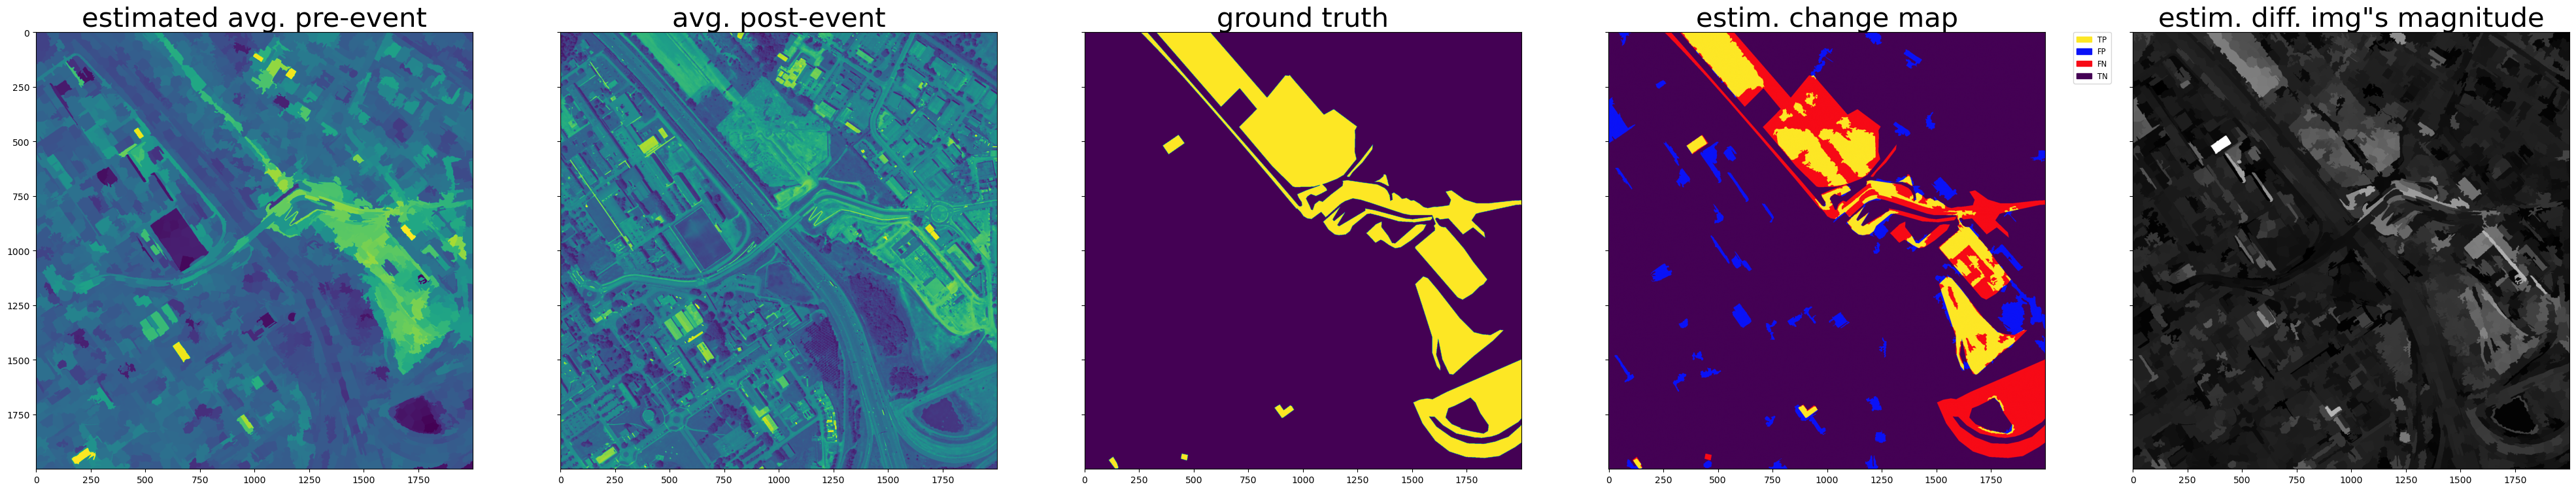

In [4]:
alg_param = {'basis_params':('2-GCN',n),
             'feature_matrix': X_mean[0],#p.hstack(X),
             'C_params':(norm, w0, epsilon),
             'gnn_init':'Gaussian',
             'maxit': n,
             'gamma0':1,
             'reversed': reverse_flag # post event assume the superposition of a pre event signal and a difference signal
             }

alg_param['display_iter'] = True # when false, it does not display progress
alg_param['disp_factor'] = 300 # display algorithm progress every other 300 iter


x1_hat, delta, history = gcd_vi_models.unsupervised_cd_estimation(X_mean[1],W1,W,alg_param)
delta_mag = np.sqrt(np.sum((delta)**2,axis=1)).reshape((n,1))    

avg_pre_event_img = gcd_utils.spixels_upsampling(np.mean(x1_hat,axis=1), segments)
diff_img_mag = gcd_utils.spixels_upsampling(delta_mag, segments)
thresholds_v01 = threshold_multiotsu(diff_img_mag,classes=2)
change_map = np.digitize(diff_img_mag, bins=thresholds_v01)

kappa, tpr, precision, conf_img_dict = gcd_utils.kappa_coeff(dataset['gt'].flatten(),change_map.flatten())

fig, ax = plt.subplots(1,5,figsize=(50,10),sharey=True)

title_list = ['estimated avg. pre-event', 'avg. post-event', 'ground truth', 'estim. change map', 'estim. diff. img"s magnitude']
ax[0].imshow(avg_pre_event_img)
ax[1].imshow(np.mean(dataset['after'],axis=2) if dataset['after'].ndim > 2 else dataset['after'])
ax[2].imshow(dataset['gt'])
#ax[3].imshow(change_map)
n1,n2 = segments.shape
gcd_utils.plot_confusion_img_on_ax(conf_img_dict,n1,n2,ax[3],add_legend=True,default_loc = True)
ax[4].imshow(diff_img_mag, cmap='gray')

for title_idx in range(len(title_list)):
    ax[title_idx].set_title(title_list[title_idx],fontsize=30)

print('metrics: kappa:', kappa, 'tpr:', tpr, 'precision:', precision)



#ax[2].plot(history['norm_w'])

To test the effects of random initialization, we now set the unsupervised approach with the 2-GCN back-end initialized with random weights following a Uniform distribution.

iter: 0 phi_1: [6.22669968] phi_2: [0.]
iter: 300 phi_1: [1.64844929] phi_2: [0.]
iter: 600 phi_1: [1.60648355] phi_2: [0.]
iter: 900 phi_1: [1.57576523] phi_2: [0.]
iter: 1200 phi_1: [1.55022336] phi_2: [0.]
iter: 1500 phi_1: [1.52721037] phi_2: [0.]
iter: 1800 phi_1: [1.50557527] phi_2: [0.]
iter: 2100 phi_1: [1.48481273] phi_2: [0.]
iter: 2400 phi_1: [1.46514861] phi_2: [0.00027666]
iter: 2700 phi_1: [1.44628122] phi_2: [0.00031736]
iter: 3000 phi_1: [1.42798737] phi_2: [0.00036091]
iter: 3300 phi_1: [1.41022972] phi_2: [0.00040599]
iter: 3600 phi_1: [1.41728613] phi_2: [0.0309078]
iter: 3900 phi_1: [1.40653186] phi_2: [0.0049608]
iter: 4200 phi_1: [1.39075549] phi_2: [0.00342169]
iter: 4500 phi_1: [1.37545215] phi_2: [0.00311844]
iter: 4800 phi_1: [1.36068698] phi_2: [0.00307655]
iter: 5100 phi_1: [1.34638406] phi_2: [0.00311275]
metrics: kappa: 0.4339792119926409 tpr: 0.40611377 precision: 0.650191


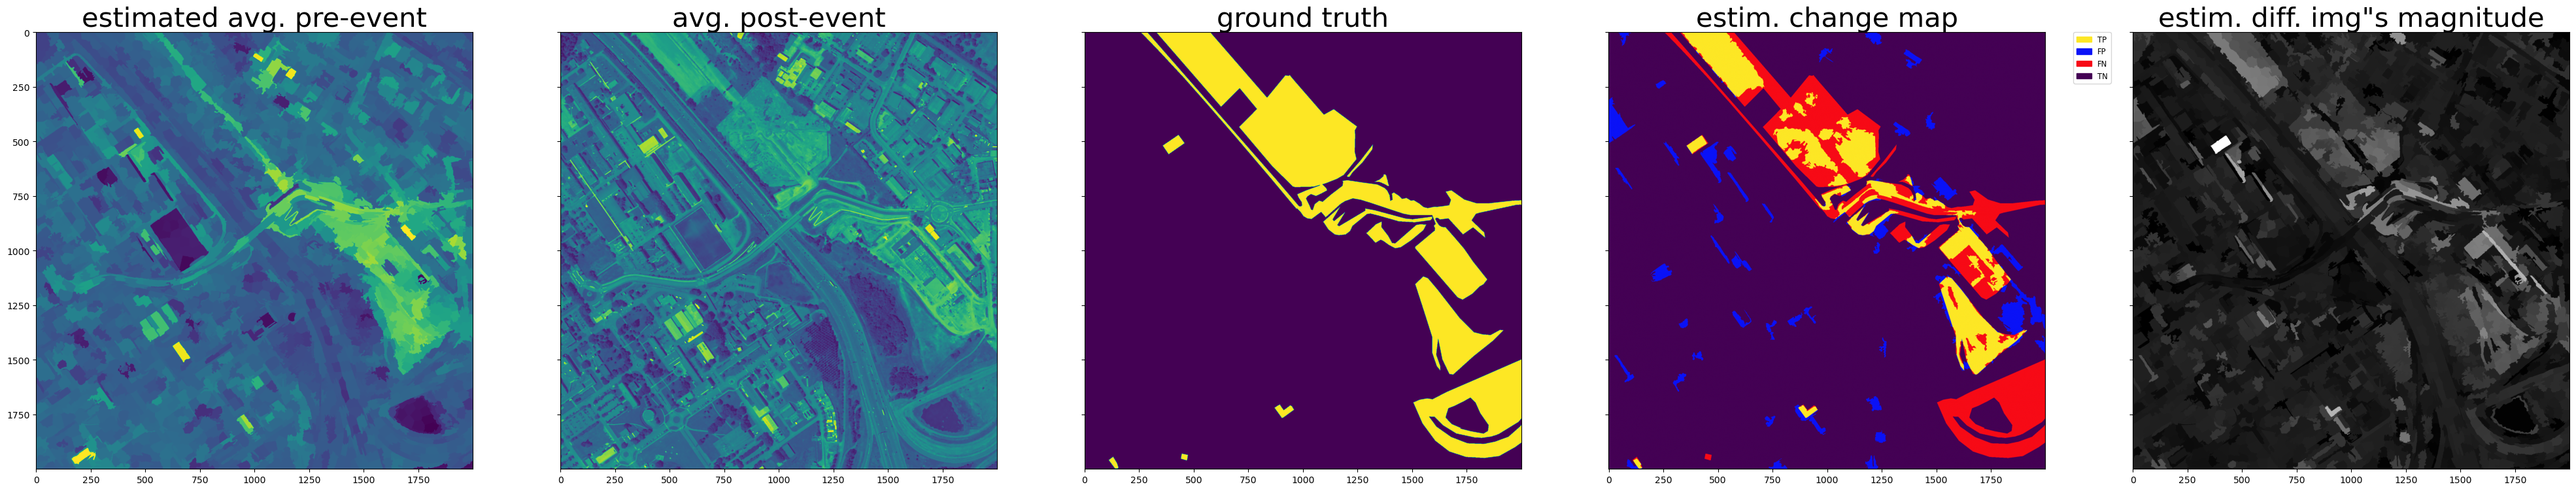

In [6]:
alg_param = {'basis_params':('2-GCN',n),
             'feature_matrix': X_mean[0],#p.hstack(X),
             'gnn_init':'Uniform',
             'C_params':(norm, w0, epsilon),
             'maxit': n,
             'gamma0':1,
             'reversed': reverse_flag # post event assume the superposition of a pre event signal and a difference signal
             }

alg_param['display_iter'] = True # when false, it does not display progress
alg_param['disp_factor'] = 300 # display algorithm progress every other 300 iter


x1_hat, delta, history = gcd_vi_models.unsupervised_cd_estimation(X_mean[1],W1,W,alg_param)
delta_mag = np.sqrt(np.sum((delta)**2,axis=1)).reshape((n,1))    

avg_pre_event_img = gcd_utils.spixels_upsampling(np.mean(x1_hat,axis=1), segments)
diff_img_mag = gcd_utils.spixels_upsampling(delta_mag, segments)
thresholds_v01 = threshold_multiotsu(diff_img_mag,classes=2)
change_map = np.digitize(diff_img_mag, bins=thresholds_v01)

kappa, tpr, precision, conf_img_dict = gcd_utils.kappa_coeff(dataset['gt'].flatten(),change_map.flatten())

fig, ax = plt.subplots(1,5,figsize=(50,10),sharey=True)

title_list = ['estimated avg. pre-event', 'avg. post-event', 'ground truth', 'estim. change map', 'estim. diff. img"s magnitude']
ax[0].imshow(avg_pre_event_img)
ax[1].imshow(np.mean(dataset['after'],axis=2) if dataset['after'].ndim > 2 else dataset['after'])
ax[2].imshow(dataset['gt'])
#ax[3].imshow(change_map)
n1,n2 = segments.shape
gcd_utils.plot_confusion_img_on_ax(conf_img_dict,n1,n2,ax[3],add_legend=True,default_loc = True)
ax[4].imshow(diff_img_mag, cmap='gray')

for title_idx in range(len(title_list)):
    ax[title_idx].set_title(title_list[title_idx],fontsize=30)

print('metrics: kappa:', kappa, 'tpr:', tpr, 'precision:', precision)


